# Fraud Detection in Card Portfolio Transactions

## Abstract

This project presents a comprehensive fraud detection framework for identifying suspicious activity within a card transactions portfolio. Developed for a consulting context, it combines both domain expertise and data science rigor to address the practical challenge of minimizing financial fraud while maintaining operational efficiency.

The analysis begins with a structured exploratory assessment of transaction-level data, highlighting key variables such as transaction amount, card presence, e-commerce activity, 3D Secure usage, and wallet types. A set of interpretable, business-driven fraud rules is then designed based on industry heuristics, forming the baseline for a rule-based fraud alert system.

To improve detection performance, a logistic regression model is developed using carefully selected features, offering a balance between predictive power and interpretability. Model outputs are benchmarked against the rule-based system using a set of custom KPIs relevant to the banking sector — including detection rate, false positive rate, and traditional classification metrics.

Throughout the notebook, special attention is given to interpretability, business relevance, and actionable insights. The dual-model approach not only demonstrates technical competence but also reflects a strategic consulting mindset: combining expert knowledge with data-driven optimization to create solutions that are both effective and trusted by business stakeholders.

## Imports

In [ ]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from src.LoggerClass import FraudRuleLogger

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import warnings
from sklearn.exceptions import ConvergenceWarning

import streamlit as st

## View Data

In [ ]:
# Load Dataset
df = pd.read_csv("data_rules.csv")

In [3]:
# View Data
df.head()

,drn,customer_id,masked_pan,datetime,card_present,ecommerce,3ds,wallet,country,amount,...,first_trx_abroad_nonsec_ecom,high_risk_country_trx_nonsec_nonwallet,first_wallet_cp_nonsec_debcre_hour_trx,first_wallet_cnp_nonsec_trx,time_diff_3_cp_analysis,time_diff_3_cnp_analysis,gr_ecom_nonsec_transaction,z_score_flag,lr_flag_0_2,alert
0,TXN0040287,CUST000000,**** **** **** 1226,2024-04-26 02:55:26,1,0,0,NaN,IE,194.76,...,0,0,0,0,0,0,0,0,0,0
1,TXN0060050,CUST000000,**** **** **** 2369,2024-03-13 14:41:50,1,0,0,NaN,IT,50.29,...,0,0,0,0,0,0,0,0,0,0
2,TXN0068801,CUST000000,**** **** **** 4541,2023-12-26 22:46:59,0,1,0,NaN,BE,8.64,...,0,0,0,0,0,0,0,0,0,0
3,TXN0044653,CUST000000,**** **** **** 8664,2024-03-13 17:17:04,0,1,0,NaN,PK,58.02,...,0,0,0,0,0,0,0,0,0,0
4,TXN0031890,CUST000000,**** **** **** 8743,2024-03-14 03:02:38,1,0,0,NaN,BE,75.16,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134560 entries, 0 to 134559
Data columns (total 33 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   drn                                     134560 non-null  object 
 1   customer_id                             134560 non-null  object 
 2   masked_pan                              134560 non-null  object 
 3   datetime                                134560 non-null  object 
 4   card_present                            134560 non-null  int64  
 5   ecommerce                               134560 non-null  int64  
 6   3ds                                     134560 non-null  int64  
 7   wallet                                  46054 non-null   object 
 8   country                                 134560 non-null  object 
 9   amount                                  134560 non-null  float64
 10  card_type                               1345

## Modelling

### Score Base Model
We will start with a __Score Base Model__.

This score model becomes the baseline:
- Any ML model must outperform it to justify the added complexity
- Tthis score can be added as a feature in the ML model.

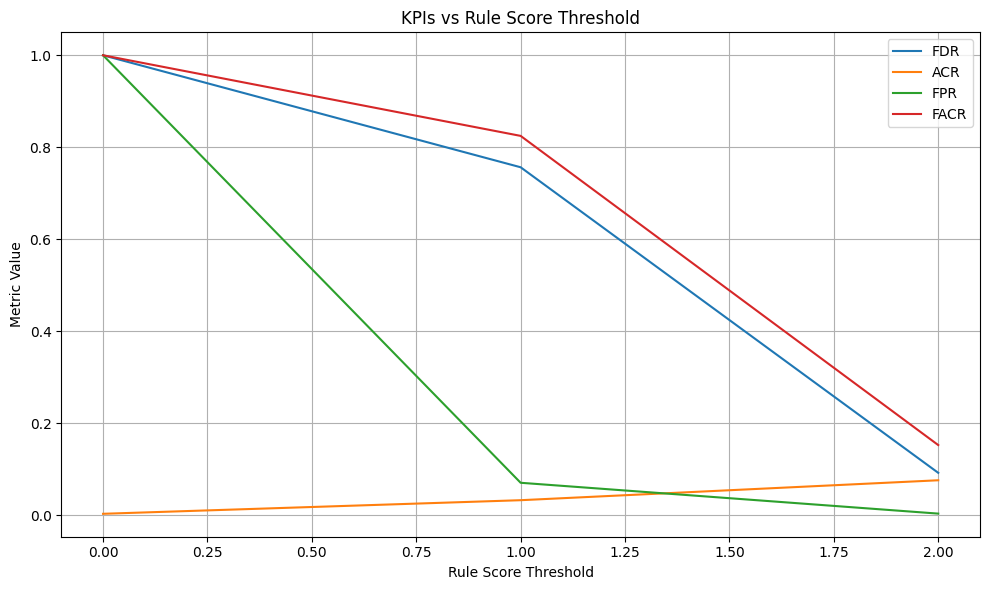

In [5]:
rule_columns = ['first_trx_abroad_nonsec_ecom',
       'high_risk_country_trx_nonsec_nonwallet',
       'first_wallet_cp_nonsec_debcre_hour_trx', 
       'first_wallet_cnp_nonsec_trx',
       'time_diff_3_cp_analysis', 
       'time_diff_3_cnp_analysis',
       'gr_ecom_nonsec_transaction', 
       'z_score_flag']

df["rule_score"] = df[rule_columns].sum(axis=1)

def evaluate_score_thresholds(df, score_col = 'rule_score', label_col = 'fraud_label', amount_col = 'amount'):
    thresholds = sorted(df[score_col].unique())
    metrics = {
        "threshold": [],
        "FDR": [],
        "ACR": [],
        "FPR": [],
        "FACR": [],
    }

    for t in thresholds:
        df["predicted"] = (df[score_col] >= t).astype(int)

        TP = ((df["predicted"] == 1) & (df[label_col] == 1)).sum()
        FP = ((df["predicted"] == 1) & (df[label_col] == 0)).sum()
        FN = ((df["predicted"] == 0) & (df[label_col] == 1)).sum()
        TN = ((df["predicted"] == 0) & (df[label_col] == 0)).sum()

        total_alerts = TP + FP
        total_frauds = TP + FN
        total_legit = TN + FP
        total_fraud_amount = df[df[label_col] == 1][amount_col].sum()
        captured_amount = df[(df["predicted"] == 1) & (df[label_col] == 1)][amount_col].sum()

        metrics["threshold"].append(t)
        metrics["FDR"].append(TP / total_frauds if total_frauds else 0)
        metrics["ACR"].append(TP / total_alerts if total_alerts else 0)
        metrics["FPR"].append(FP / total_legit if total_legit else 0)
        metrics["FACR"].append(captured_amount / total_fraud_amount if total_fraud_amount else 0)

    return pd.DataFrame(metrics)

# Run the evaluation
score_metrics = evaluate_score_thresholds(df, "rule_score", "fraud_label", "amount")

# Plot KPIs
plt.figure(figsize=(10, 6))
plt.plot(score_metrics["threshold"], score_metrics["FDR"], label="FDR")
plt.plot(score_metrics["threshold"], score_metrics["ACR"], label="ACR")
plt.plot(score_metrics["threshold"], score_metrics["FPR"], label="FPR")
plt.plot(score_metrics["threshold"], score_metrics["FACR"], label="FACR")
plt.xlabel("Rule Score Threshold")
plt.ylabel("Metric Value")
plt.title("KPIs vs Rule Score Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


_We evaluated different thresholds for our rule-based score. 
A threshold of ≥ 1 balances fraud detection with operational load. 
It retains ~75% of frauds while reducing false positives by over 90%, and it captures over 80% of the fraud amount_

### Logistic Regression

1. **Data Preparation**
   - Applied `train_test_split` with `stratify=y` to preserve fraud/non-fraud ratio.

2. **Model Selection**
   - Used **Logistic Regression** with:
     - `penalty='l1'` (Lasso Regularization) for feature selection.
     - `class_weight='balanced'` to handle class imbalance.
     - `solver='liblinear'` for compatibility with L1.
   - Extracted selected features via non-zero coefficients.

3. **Hyperparameter Tuning**
   - Explored multiple **test sizes** (0.2, 0.3, 0.4, 0.5) to find best split.
   - Tuned `max_iter` values (100 to 5000) and selected the lowest converging value (500).
   - Evaluated **thresholds** from 0.1 to 0.9 to optimize for custom KPIs.

4. **Evaluation Metrics**
   - Computed four key KPIs:
     - **FDR**: Fraud Detection Rate
     - **ACR**: Alert Conversion Rate (precision)
     - **FPR**: False Positive Rate
     - **FACR**: Fraud Amount Captured Rate

In [6]:
rule_columns = [
    'first_trx_abroad_nonsec_ecom',
    'high_risk_country_trx_nonsec_nonwallet',
    'first_wallet_cp_nonsec_debcre_hour_trx', 
    'first_wallet_cnp_nonsec_trx',
    'time_diff_3_cp_analysis', 
    'time_diff_3_cnp_analysis',
    'gr_ecom_nonsec_transaction', 
    'z_score_flag'
]

additional_columns = ['ecommerce', '3ds', 'card_present', 'is_wallet']
def evaluate_test_sizes(X, y, test_sizes=[0.2, 0.3, 0.4, 0.5], max_iter=2000):
    results = []
    for size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, test_size=size, random_state=42
        )
        model = LogisticRegression(
            penalty='l1', solver='liblinear', class_weight='balanced', max_iter=max_iter
        )
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        print(f"\n--- Test Size: {size} ---")
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

        results.append({
            'test_size': size,
            'roc_auc': roc_auc_score(y_test, y_proba)
        })

    return pd.DataFrame(results)


def evaluate_iterations(X_train, y_train, iter_counts=[100, 500, 1000, 2000, 5000]):
    iteration_results = []
    for iter_count in iter_counts:
        model = LogisticRegression(
            penalty='l1', solver='liblinear', class_weight='balanced', max_iter=iter_count
        )
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", ConvergenceWarning)
            model.fit(X_train, y_train)
            converged = len(w) == 0

        coef_magnitude = np.sum(np.abs(model.coef_))
        iteration_results.append({
            'iterations': iter_count,
            'converged': converged,
            'coef_magnitude_sum': coef_magnitude
        })

    return pd.DataFrame(iteration_results)


def evaluate_thresholds(model, X_test, y_test, thresholds=np.arange(0.3, 0.8, 0.1)):
    y_scores = model.predict_proba(X_test)[:, 1]

    # Precision-Recall Curve
    precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_scores)

    plt.figure(figsize=(8, 5))
    plt.plot(pr_thresholds, precisions[:-1], label='Precision')
    plt.plot(pr_thresholds, recalls[:-1], label='Recall')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision-Recall vs Threshold")
    plt.grid()
    plt.legend()
    plt.show()

    # Print classification reports
    for thresh in thresholds:
        preds = (y_scores >= thresh).astype(int)
        print(f"\n--- Threshold: {thresh:.2f} ---")
        print(classification_report(y_test, preds))

def evaluate_custom_kpis(y_true, y_pred, y_scores, test_index, df, threshold=0.5):
    # Align test DataFrame
    test_df = df.loc[test_index].reset_index(drop=True)

    # Convert y_true/y_pred to Series if needed, and reset index
    y_true_aligned = pd.Series(y_true).reset_index(drop=True)
    y_pred_aligned = pd.Series(y_pred).reset_index(drop=True)

    # Confusion matrix elements
    TP = ((y_pred_aligned == 1) & (y_true_aligned == 1)).sum()
    FP = ((y_pred_aligned == 1) & (y_true_aligned == 0)).sum()
    FN = ((y_pred_aligned == 0) & (y_true_aligned == 1)).sum()
    TN = ((y_pred_aligned == 0) & (y_true_aligned == 0)).sum()

    total_alerts = TP + FP
    total_frauds = TP + FN
    total_legit = TN + FP

    # Amount-based KPIs
    total_fraud_amount = test_df.loc[y_true_aligned == 1, 'amount'].sum()
    captured_amount = test_df.loc[(y_true_aligned == 1) & (y_pred_aligned == 1), 'amount'].sum()

    # Final KPIs
    fdr = TP / total_frauds if total_frauds else 0
    acr = TP / total_alerts if total_alerts else 0
    fpr = FP / total_legit if total_legit else 0
    facr = captured_amount / total_fraud_amount if total_fraud_amount else 0

    return pd.DataFrame({
        "Metric": ["FDR", "ACR", "FPR", "FACR"],
        "Value": [fdr * 100, acr * 100, fpr * 100, facr * 100],
        "Threshold": [threshold] * 4
    })

def evaluate_custom_kpis_over_thresholds(model, X_test, y_test, df, thresholds=np.arange(0.1, 0.91, 0.1)):
    all_kpis = []

    y_scores = model.predict_proba(X_test)[:, 1]

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        kpis = evaluate_custom_kpis(y_test, y_pred, y_scores, X_test.index, df, threshold)
        all_kpis.append(kpis)

    # Combine all KPI results into one DataFrame
    kpi_df = pd.concat(all_kpis, ignore_index=True)

    # Plot each KPI over thresholds
    plt.figure(figsize=(10, 6))
    for metric in ["FDR", "ACR", "FPR", "FACR"]:
        metric_data = kpi_df[kpi_df["Metric"] == metric]
        plt.plot(metric_data["Threshold"], metric_data["Value"], label=metric)

    plt.xlabel("Threshold")
    plt.ylabel("KPI Value (%)")
    plt.title("Custom KPIs vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return kpi_df
selected_features = rule_columns + additional_columns
X = df[selected_features].copy()
y = df['fraud_label']
test_size_results = []

# ---------------------------
# STAGE 1: Evaluate Test Sizes
# ---------------------------
for test_size in [0.2, 0.3, 0.4, 0.5]:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    model = LogisticRegression(
        penalty='l1', solver='liblinear', class_weight='balanced', max_iter=2000
    )
    model.fit(X_train, y_train)

    # L1: Keep only features with non-zero coefficients
    selected_features = np.array(X.columns)[model.coef_[0] != 0]
    X_test_selected = X_test[selected_features]
    X_train_selected = X_train[selected_features]

    # Refit with selected features
    model.fit(X_train_selected, y_train)
    y_scores = model.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_scores >= 0.5).astype(int)

    kpis = evaluate_custom_kpis(y_test, y_pred, y_scores, X_test_selected.index, df, threshold=0.5)
    kpis["Test Size"] = test_size
    kpis["Selected Features"] = ", ".join(selected_features)
    test_size_results.append(kpis)

test_size_kpis = pd.concat(test_size_results, ignore_index=True)
test_size_kpis

,Metric,Value,Threshold,Test Size,Selected Features
0,FDR,80.000000,0.5,0.2,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
1,ACR,1.871216,0.5,0.2,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
2,FPR,13.292578,0.5,0.2,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
3,FACR,85.656218,0.5,0.2,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
4,FDR,78.740157,0.5,0.3,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
5,ACR,1.810610,0.5,0.3,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
6,FPR,13.476305,0.5,0.3,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
7,FACR,85.129348,0.5,0.3,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
8,FDR,80.473373,0.5,0.4,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
9,ACR,1.834367,0.5,0.4,"first_trx_abroad_nonsec_ecom, high_risk_countr..."


We proceed with test size of 0.4 since:

- Best FACR (86.51%) — we recover the most fraudulent money

- Strong FDR (80.47%) — still catch ~80% of actual frauds

- Very slightly higher FPR than others (13.5%) — acceptable tradeoff

- Strong ACR (1.83%)

In [7]:
iteration_results = []

# ----------------------------
# STAGE 2: Evaluate Iterations
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

for max_iter in [100, 500, 1000, 2000, 5000]:
    model = LogisticRegression(
        penalty='l1', solver='liblinear', class_weight='balanced', max_iter=max_iter
    )
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        model.fit(X_train, y_train)
        converged = len(w) == 0

    selected_features = np.array(X.columns)[model.coef_[0] != 0]
    X_test_selected = X_test[selected_features]
    X_train_selected = X_train[selected_features]

    model.fit(X_train_selected, y_train)
    y_scores = model.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_scores >= 0.5).astype(int)

    kpis = evaluate_custom_kpis(y_test, y_pred, y_scores, X_test_selected.index, df, threshold=0.5)
    kpis["Max Iter"] = max_iter
    kpis["Converged"] = converged
    kpis["Selected Features"] = ", ".join(selected_features)
    iteration_results.append(kpis)

iteration_kpis = pd.concat(iteration_results, ignore_index=True)
iteration_kpis


,Metric,Value,Threshold,Max Iter,Converged,Selected Features
0,FDR,80.473373,0.5,100,False,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
1,ACR,1.834367,0.5,100,False,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
2,FPR,13.564439,0.5,100,False,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
3,FACR,86.512721,0.5,100,False,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
4,FDR,80.473373,0.5,500,True,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
5,ACR,1.834367,0.5,500,True,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
6,FPR,13.564439,0.5,500,True,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
7,FACR,86.512721,0.5,500,True,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
8,FDR,80.473373,0.5,1000,True,"first_trx_abroad_nonsec_ecom, high_risk_countr..."
9,ACR,1.834367,0.5,1000,True,"first_trx_abroad_nonsec_ecom, high_risk_countr..."


We proceed with iteration run of 500 since iterations larger than 500 yield the exact same results and iteration size of 100 failed to converge.

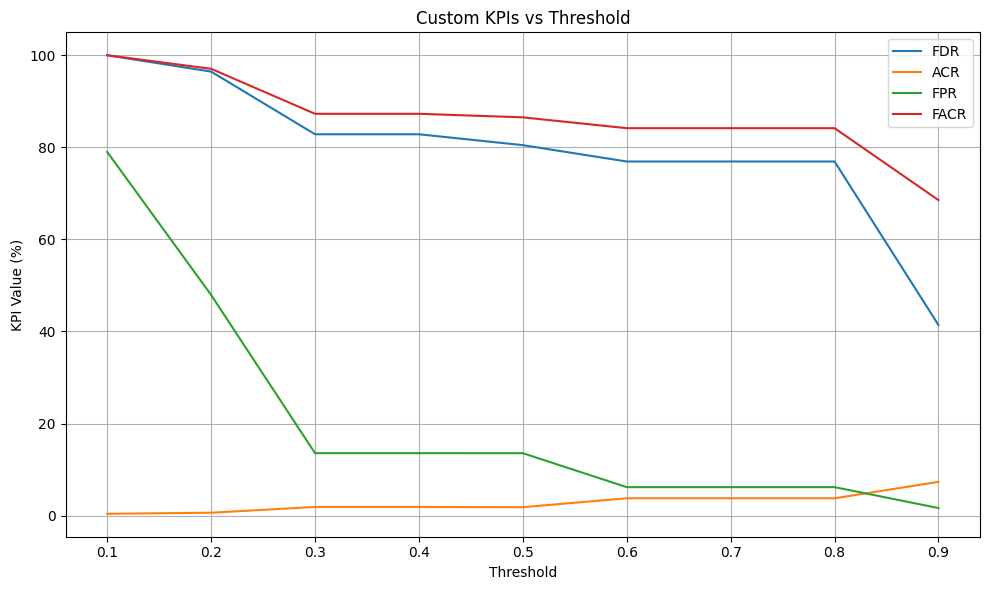

,Metric,Value,Threshold
0,FDR,100.000000,0.1
1,ACR,0.397142,0.1
2,FPR,78.995434,0.1
3,FACR,100.000000,0.1
4,FDR,96.449704,0.2
5,ACR,0.629733,0.2
6,FPR,47.937750,0.2
7,FACR,97.061026,0.2
8,FDR,82.840237,0.3
9,ACR,1.886538,0.3


In [8]:

# ----------------------------
# STAGE 3: Evaluate Thresholds
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

model = LogisticRegression(
    penalty='l1', solver='liblinear', class_weight='balanced', max_iter=500
)
model.fit(X_train, y_train)

selected_features = np.array(X.columns)[model.coef_[0] != 0]
X_test_selected = X_test[selected_features]
X_train_selected = X_train[selected_features]

model.fit(X_train_selected, y_train)

# Visualize and return KPIs across thresholds
threshold_kpis = evaluate_custom_kpis_over_thresholds(model, X_test_selected, y_test, df)
threshold_kpis

We proceed with threshold of 0.6 to balance FPR with Fraud captured and Amount Saved.

| KPI                                | Logistic Regression | Score Base Model |Industry Benchmark         |
|------------------------------------|----------------------|-|----------------------------|
| **ACR (Alert Conversion Rate)**     | 3.59%               | 3.76% |≥ 1–5%                      |
| **FDR (Fraud Detection Rate)**      | 76.92%              |76.92% |≥ 90–95%                    |
| **FPR (False Positive Rate)**       | 6.50%               | 6.19% |≤ 1–5%                      |
| **FACR (Fraud Amount Captured Rate)**| 84.16%              | 84.16%| > 80% (desirable)           |

---

- **ACR** and **FACR** meet industry standards.
- **FDR** is slightly below target (76.9% vs 90%+), indicating missed fraud cases.
- **FPR** is above industry threshold (6.5% vs ≤5%), suggesting too many false alarms.

Further improvement could involve:
- Trying ensemble models (e.g., XGBoost, Random Forest)
- Engineering new features
- Calibrating thresholds more aggressively
- Using anomaly detection or semi-supervised learning for rare frauds
- Adding more nuanced characteristics (Demographics, MCCs)
- Adding full historicity

## Risk Scoring System

__Why Build a Risk-Based Fraud Model?__

Traditional fraud systems classify transactions as either **fraudulent or not**, producing alerts that are typically reviewed **in the order they are received**. This method has two major limitations:

- It **treats all alerts equally**, regardless of how damaging the transaction might be.
- It **does not prioritize high-risk cases**, potentially delaying action on critical fraud events.

---

__The Value of Risk Scoring__

By introducing a **Risk Score** for each transaction, we shift from binary classification to a **risk-informed prioritization system**:

__Risk Score Formula:__

_Risk = P(Fraud) x Amount x Number of Rules Triggered_

Where:
- **P(fraud)**: Probability from the machine learning model
- **Amount**: Monetary value of the transaction
- **Rule Score**: Number of risk rules triggered by the transaction

---

__Key Benefits__

_Prioritized Alert Handling_

- Alerts can now be sorted by **risk severity**, not just arrival time.
- Investigators focus on the **highest-risk alerts first** — maximizing fraud prevention impact.

_Smarter Resource Allocation_

- Risk-based prioritization enables:
  - **Triage teams** to handle low/medium risk cases
  - **Expert analysts** to handle top-tier high-risk alerts
- Helps reduce backlog while maintaining quality

- Utilize Artificial Intelligence to address small risk transactions.

In [9]:
y_scores = model.predict_proba(X_test_selected)[:, 1]

test_df = df.loc[X_test_selected.index].copy()

test_df["fraud_probability"] = y_scores
test_df["risk_score"] = (
    test_df["fraud_probability"] * test_df["amount"] * test_df["rule_score"]
)

prioritized_alerts = test_df.sort_values("risk_score", ascending=False)

prioritized_alerts[["fraud_probability", "amount", "rule_score", "risk_score"]].head(20)

,fraud_probability,amount,rule_score,risk_score
76332,0.948132,1108.41,2,2101.837340
6179,0.959389,1740.86,1,1670.162737
34239,0.948132,653.77,2,1239.720138
88060,0.959389,1172.79,1,1125.162366
48270,0.959389,1168.60,1,1121.142524
17321,0.948132,572.50,2,1085.610810
32060,0.948132,550.61,2,1044.101603
97270,0.959389,1042.63,1,1000.288234
30071,0.948132,524.48,2,994.552240
78835,0.948132,475.69,2,902.033548


## Insight Generation (Chat-bot precursor)

In addition to flagging transactions with high fraud probability, we propose generating a separate `Insights_df` that helps fraud officers understand why a transaction was flagged—using human-readable explanations of the triggered rules.

The goal is to transform each high-risk transaction into a brief, natural-language summary of the situation so that fraud officers can:

- Quickly grasp the context of the alert.
- Focus investigations based on explanation, not just risk scores.
- Make faster and better-informed decisions.

Example output of `Insights_df`:

| drn        | first_trx_abroad_nonsec_ecom                             | high_risk_country_trx_nonsec_nonwallet                        |
|------------|----------------------------------------------------------|---------------------------------------------------------------|
| 0000101010 | First transaction abroad made on a non-secure e-com site |                                                               |
| 0000102020 |                                                          | Transaction from a high-risk country on non-secure platform   |

Only transactions with fraud probability > 0.5 are included, focusing the output on cases that truly require attention.

Why this is valuable:

- Explainability: Replaces cryptic rule names with clear, natural-language case descriptions.
- Investigation efficiency: Fraud officers save time by seeing the rationale up front.
- Documentation support: Can be used in audit trails or as a case summary.
- Focus on high-risk cases: Only applies to high-probability transactions (e.g., P(fraud) > 0.5).
- Scalable and extendable: New rules and explanations can easily be added to the system.

How it works:

1. Evaluate fraud probability using the trained logistic regression model.
2. For each transaction with P(fraud) > 0.5, check which binary rule columns are active (equal to 1).
3. Translate each triggered rule into a plain-text explanation.
4. Store results in a new `Insights_df` indexed by transaction identifier (`drn`).

By bridging the gap between model output and human understanding, this system ensures that alerts are not only prioritized but also clearly understood.

In [10]:
# Step 1: Define rule descriptions
rule_descriptions = {
    "first_trx_abroad_nonsec_ecom": "First transaction abroad performed on a non-secure e-commerce site.",
    "high_risk_country_trx_nonsec_nonwallet": "Transaction originated from a high-risk country using a non-secure, non-wallet method.",
    "first_wallet_cp_nonsec_debcre_hour_trx": "First wallet transaction with card-present on a non-secure merchant during a high-risk hour.",
    "first_wallet_cnp_nonsec_trx": "First wallet transaction with card-not-present on a non-secure channel.",
    "time_diff_3_cp_analysis": "Card-present transaction occurred unusually soon after a previous transaction, indicating abnormal timing."
}

# Step 2: Generate fraud probabilities
y_scores = model.predict_proba(X_test_selected)[:, 1]

# Step 3: Filter high-risk transactions
test_df = df.loc[X_test_selected.index].copy()
test_df["fraud_probability"] = y_scores
flagged = test_df[test_df["fraud_probability"] > 0.6].copy()

# Step 4: Build Insights_df
insight_rows = []

for _, row in flagged.iterrows():
    insight = {"drn": row["drn"]}
    for rule_col, description in rule_descriptions.items():
        if rule_col in row and row[rule_col] == 1:
            insight[rule_col] = description
        else:
            insight[rule_col] = ""
    insight_rows.append(insight)

Insights_df = pd.DataFrame(insight_rows)

# Preview the result
Insights_df

,drn,first_trx_abroad_nonsec_ecom,high_risk_country_trx_nonsec_nonwallet,first_wallet_cp_nonsec_debcre_hour_trx,first_wallet_cnp_nonsec_trx,time_diff_3_cp_analysis
0,TXN0064235,First transaction abroad performed on a non-se...,,,,
1,TXN0044756,First transaction abroad performed on a non-se...,,,,
2,SYN_CP_CNP_1_0_0_01088,,,First wallet transaction with card-present on ...,,
3,SYN_CP_CNP_0_1_0_01245,,,,First wallet transaction with card-not-present...,
4,TXN0006351,First transaction abroad performed on a non-se...,,,,
...,...,...,...,...,...,...
3445,SYN_CP_CNP_1_0_0_02084,,,First wallet transaction with card-present on ...,,
3446,SYN_CP_CNP_0_1_0_02548,,,,First wallet transaction with card-not-present...,
3447,SYN_CP_CNP_0_1_0_00361,,,,First wallet transaction with card-not-present...,
3448,TXN0094116,First transaction abroad performed on a non-se...,,,,


## Final Conclusion
This notebook presents an ML approach to fraud detection in the card transactions portfolio of a financial institution. It combines data science, business logic, and interface deployment — aligning technical effectiveness with client-facing usability.

---

### **Data Exploration and Feature Understanding**

The project begins with thorough **Exploratory Data Analysis (EDA)**, providing a comprehensive view of the dataset's structure, class imbalance (~0.27% fraud), and key variables. A feature dictionary clarified each column’s relevance, laying the groundwork for responsible modeling and stakeholder transparency.

---

### **Fraud Rule Engineering and Rule-Based Modeling**

We engineered **custom business rules** inspired by real-world fraud signals, such as:
- First-time usage abroad with insecure channels
- Unusual wallet behavior
- Card-not-present transactions with suspicious patterns

Each rule was followed by **KPI evaluation** (TP, FP, FN, TN), producing **actionable business metrics** used in banking fraud prevention.

These rules were aggregated to create a **rule-based benchmark system**, emulating how many banks currently detect fraud. While interpretable, this system exposed limitations, particularly in false positive rates — motivating the transition to predictive modeling.

---

### **Machine Learning Model: Logistic Regression**

A **logistic regression model** was trained using selected engineered features. The model outperformed the rules across KPIs, demonstrating improved fraud capture and fewer false positives. Logistic regression was chosen due to its:
- High interpretability
- Practical alignment with consulting requirements
- Easy communication with non-technical stakeholders

> The logistic model showed that **machine learning can augment — not replace — human-defined rules**, offering a hybrid detection strategy.

---

### **Insights Section**

The **Insights** section distilled the modeling and rules into **high-level business takeaways**:
- Which rules were most effective
- Which combinations predicted fraud well
- How the logistic model handles ambiguous transactions

This section is vital for clients, turning data into **decision-ready insights**.

---

### **Risk Scoring System**

A dedicated **Risk Scoring System** section framed fraud detection in terms of **business risk**. Key trade-offs were discussed:
- High detection - Low amouns

---

### **Streamlit Deployment**

Finally, the Streamlit application visualizes fraud activity across countries using an interactive world map. It leverages a choropleth map to highlight countries based on the number of fraud cases observed in the dataset. Countries with higher fraud counts are shaded in red, while those with no fraud appear green.

The purpose of building this tool is to provide a foundational interface for fraud analysts to visually explore geographic trends in fraud. By selecting a country, users can view summary statistics such as total transactions and fraud cases associated with that country.

At this stage, the application is an early prototype. The user interface is minimal and underdeveloped, with room for significant improvements in interactivity, design, and depth of information. Future versions may include time-based filtering, rule-level summaries, drill-downs into transaction types, or direct alert inspection. This version lays the groundwork for a more comprehensive fraud monitoring dashboard.

---
## Future Steps
### Conversational Chatbots for Clients
- Deploy an **AI-driven chatbot** to:
  - Alert users of suspicious activity in real time
  - Explain to hte fraud officers why a transaction was flagged
  - Allow users to confirm or dispute flagged transactions

### Advanced Models & Ensemble Techniques
- Explore **tree-based models** (e.g., XGBoost, LightGBM) for enhanced detection power.
- Combine rule-based outputs with model probabilities using **stacked ensembles**.

### Model Monitoring & Drift Detection
- Build dashboards to track **model drift**, **fraud patterns over time**, and **false positive rates**.
- Use business intelligence tools (e.g., Power BI, Tableau) for ongoing stakeholder visibility.

### Feedback Loops for Learning
- Incorporate human investigator feedback into the model pipeline.
- Retrain models periodically based on **confirmed fraud cases** and user disputes.